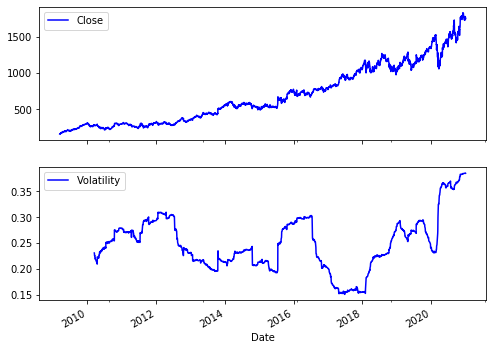

In [113]:
S0 = 100
K = 105
T = 1
r = 0.05
sigma = 0.2
from numpy import *
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import h5py
import datetime as dt
import sys
sys.path.append(r'C:\Users\pc\Desktop\stock\Py_for_Finance\tool')
from tool import BSM
import pprint as pp

I = 100000
###np를 이용한 벡터화 문법 -> MC
np.random.seed(19650507)
z = np.random.standard_normal(I)
ST = S0 * np.exp( (r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * z)  ## BSM 모형 만기 주가지수
hT = np.maximum(ST - K, 0)
C0 = np.exp( -r * T ) * np.sum(hT) / I

#print( "Value of the European Call Option %5.3f" % C0)   ## % .3f는 서식

yahoo = web.DataReader('GOOG', data_source = 'yahoo', start = '3/14/2009',
                      end = '12/31/2020')

#print(yahoo.tail())
#print(yahoo.columns)

##변동성을 구해보자
yahoo['Log_Ret'] = np.log(yahoo['Close'] / yahoo['Close'].shift(1))
yahoo['Volatility'] = yahoo['Log_Ret'].rolling(window = 252,      ###center는 중간을 중심으로 계산할지?
                                               center = False).std() * np.sqrt(252)   ##window는 몇개씩 연산할 지
### 그 변동성 시간 곱 알잖아, 1년 영업일 수 252일 로 두고 하는거

yahoo[['Close', 'Volatility']].plot(subplots = True , color = 'blue',
                                    figsize = (8 , 6))  ## 축 서식 어떻게 바꾸냐 -> 꼭 찾아볼것
plt.show()



In [114]:
h5 = pd.HDFStore("./data/vstoxx_data_31032014.h5", 'r')
futures_data = h5['futures_data']   ##선물
options_data = h5['options_data'] ##콜옵션
h5.close()
print(futures_data)
print(options_data.head())

                    DATE  EXP_YEAR  EXP_MONTH  PRICE             MATURITY  \
496  1396224000000000000      2014          4  17.85  1397779200000000000   
497  1396224000000000000      2014          5  19.55  1400198400000000000   
498  1396224000000000000      2014          6  19.95  1403222400000000000   
499  1396224000000000000      2014          7  20.40  1405641600000000000   
500  1396224000000000000      2014          8  20.70  1408060800000000000   
501  1396224000000000000      2014          9  20.95  1411084800000000000   
502  1396224000000000000      2014         10  21.05  1413504000000000000   
503  1396224000000000000      2014         11  21.25  1416528000000000000   

       TTM  
496  0.049  
497  0.126  
498  0.222  
499  0.299  
500  0.375  
501  0.471  
502  0.548  
503  0.644  
                      DATE  EXP_YEAR  EXP_MONTH TYPE  STRIKE  PRICE  \
46170  1396224000000000000      2014          4    C     1.0  16.85   
46171  1396224000000000000      2014          4

In [115]:
futures_data['DATE'] = futures_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
futures_data['MATURITY'] = futures_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
options_data['DATE'] = options_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
options_data['MATURITY'] = options_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))

In [116]:

bs = BSM.bsm_function()

tol = 0.5  ##머니니스 범위
V0 = 17.6639
r = 0.01

In [117]:
#print(options_data.loc[options_data.index[0]]["MATURITY"])
print(options_data.loc[options_data.index[0],"MATURITY"])

2014-04-18 09:00:00


In [118]:
 forward = futures_data[futures_data['MATURITY'] == \
                           options_data.loc[options_data.index[0]]['MATURITY']]['PRICE'].values[0]
print(forward)

17.85


In [119]:
print(options_data)

                     DATE  EXP_YEAR  EXP_MONTH TYPE  STRIKE  PRICE  \
46170 2014-03-31 09:00:00      2014          4    C     1.0  16.85   
46171 2014-03-31 09:00:00      2014          4    C     2.0  15.85   
46172 2014-03-31 09:00:00      2014          4    C     3.0  14.85   
46173 2014-03-31 09:00:00      2014          4    C     4.0  13.85   
46174 2014-03-31 09:00:00      2014          4    C     5.0  12.85   
...                   ...       ...        ...  ...     ...    ...   
46560 2014-03-31 09:00:00      2014         11    C    85.0   0.05   
46561 2014-03-31 09:00:00      2014         11    C    90.0   0.05   
46562 2014-03-31 09:00:00      2014         11    C    95.0   0.05   
46563 2014-03-31 09:00:00      2014         11    C   100.0   0.05   
46564 2014-03-31 09:00:00      2014         11    C   105.0   0.05   

                 MATURITY    TTM  
46170 2014-04-18 09:00:00  0.049  
46171 2014-04-18 09:00:00  0.049  
46172 2014-04-18 09:00:00  0.049  
46173 2014-04-18 09

In [129]:
imp_vol = bs.bsm_call_imp_vol(
            V0, 
            options_data.loc[46171]['STRIKE'],
            options_data.loc[46171]['TTM'],
            r, 
            options_data.loc[46171]['PRICE'],
            sigma_est=2.,  
            it= 100)
options_data.loc[46171,'IMP_VOL'] = imp_vol
print(options_data)

                     DATE            MATURITY    TTM  STRIKE  PRICE   IMP_VOL
46170 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     1.0  16.85  0.000000
46171 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     2.0  15.85  5.809018
46172 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     3.0  14.85  0.000000
46173 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     4.0  13.85  0.000000
46174 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     5.0  12.85  0.000000
...                   ...                 ...    ...     ...    ...       ...
46560 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    85.0   0.05  0.000000
46561 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    90.0   0.05  0.000000
46562 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    95.0   0.05  0.000000
46563 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644   100.0   0.05  0.000000
46564 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644   105.0   0.05  0.000000

[395 rows x 6 columns]


In [130]:
options_data = options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']]
options_data['IMP_VOL'] = 0.0 ##  내재 변동성 저장할 새로운 열
print(options_data.head())

                     DATE            MATURITY    TTM  STRIKE  PRICE  IMP_VOL
46170 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     1.0  16.85      0.0
46171 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     2.0  15.85      0.0
46172 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     3.0  14.85      0.0
46173 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     4.0  13.85      0.0
46174 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     5.0  12.85      0.0


In [131]:
for option in options_data.index:
    ## 모든 옵션 시장가에 대해 반복   
    forward = futures_data[futures_data['MATURITY'] == \
                           options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    ###옵션과 만기가 일치하는 선물 선택
    if  forward * (1 - tol) < options_data.loc[option]['STRIKE'] and options_data.loc[option]['STRIKE'] < forward * (1 + tol):

        imp_vol = bs.bsm_call_imp_vol(
            V0, # VSTOXX지수값
            options_data.loc[option]['STRIKE'],
            options_data.loc[option]['TTM'],
            r, # 단기이자율
            options_data.loc[option]['PRICE'],
            sigma_est=2.,  ##내재변동성 초기 추정치
            it= 100)   ## 이터레이션
        
        options_data.loc[option,'IMP_VOL'] = imp_vol
    

In [136]:
print(options_data)

                     DATE            MATURITY    TTM  STRIKE  PRICE  IMP_VOL
46170 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     1.0  16.85      0.0
46171 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     2.0  15.85      0.0
46172 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     3.0  14.85      0.0
46173 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     4.0  13.85      0.0
46174 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     5.0  12.85      0.0
...                   ...                 ...    ...     ...    ...      ...
46560 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    85.0   0.05      0.0
46561 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    90.0   0.05      0.0
46562 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    95.0   0.05      0.0
46563 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644   100.0   0.05      0.0
46564 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644   105.0   0.05      0.0

[395 rows x 6 columns]


In [133]:
print(options_data.loc[46170])

DATE        2014-03-31 09:00:00
MATURITY    2014-04-18 09:00:00
TTM                       0.049
STRIKE                        1
PRICE                     16.85
IMP_VOL                       0
Name: 46170, dtype: object


In [137]:
cond = (options_data['IMP_VOL'] > 0)
plot_data = options_data[cond]
print(plot_data)

                     DATE            MATURITY    TTM  STRIKE  PRICE   IMP_VOL
46178 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049     9.0   8.85  2.083386
46179 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049    10.0   7.85  1.804194
46180 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049    11.0   6.85  1.550283
46181 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049    12.0   5.85  1.316103
46182 2014-03-31 09:00:00 2014-04-18 09:00:00  0.049    13.0   4.85  1.097184
...                   ...                 ...    ...     ...    ...       ...
46541 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    26.0   2.20  0.785411
46542 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    27.0   2.05  0.789241
46543 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    28.0   1.95  0.800016
46544 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    29.0   1.80  0.798958
46545 2014-03-31 09:00:00 2014-11-21 09:00:00  0.644    30.0   1.70  0.805459

[158 rows x 6 columns]


In [75]:
print(max(options_data["IMP_VOL"]))

5.809017622261663


In [76]:
print(futures_data['MATURITY'])

496   2014-04-18 09:00:00
497   2014-05-16 09:00:00
498   2014-06-20 09:00:00
499   2014-07-18 09:00:00
500   2014-08-15 09:00:00
501   2014-09-19 09:00:00
502   2014-10-17 09:00:00
503   2014-11-21 09:00:00
Name: MATURITY, dtype: datetime64[ns]


In [77]:
maturities = sorted(set(options_data['MATURITY']))
pp.pprint(maturities)


[Timestamp('2014-04-18 09:00:00'),
 Timestamp('2014-05-16 09:00:00'),
 Timestamp('2014-06-20 09:00:00'),
 Timestamp('2014-07-18 09:00:00'),
 Timestamp('2014-08-15 09:00:00'),
 Timestamp('2014-09-19 09:00:00'),
 Timestamp('2014-10-17 09:00:00'),
 Timestamp('2014-11-21 09:00:00')]


In [78]:
print(max(plot_data['IMP_VOL']))

5.809017622261663


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series 

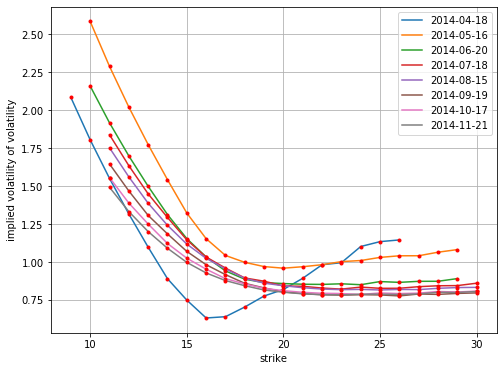

In [138]:

plt.figure(figsize= ( 8, 6))
for maturity in maturities:
    data = plot_data[options_data["MATURITY"] == maturity]   ### colum을 이렇게도 부를 수 있구나 !!!
    ## 만기 같은것들끼리 솎아서
    plt.plot(data['STRIKE'], data['IMP_VOL'],
             label=maturity.date(), lw = 1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
    plt.grid(True)
    plt.xlabel('strike')
    plt.ylabel('implied volatility of volatility')
    plt.legend()
plt.show()